# Mantis Finite Difference 
### Author: G. Papageorgiou
In this notebook we showcase the setup for our staggered grid, 2D anisotropic viscoelastic finite difference code in the mantis codebase.

In [1]:
%load_ext autoreload
%autoreload 2
import mantis_wave_modelling.finite_difference.parameter_handling as manFD


First we generate grids based on a layered model. This is coupled to the rock physics modelling library. Here for simplicity we choose the `generic` (identity) model.

In [2]:
input = {
    0: {"Top Depth": 0.0, "Vp": 2.82, "Vs": 1.25, "Rho": 2.35},
    1: {"Top Depth": 100.0, "Vp": 3.55, "Vs": 1.47, "Rho": 2.45},
    2: {"Top Depth": 300.0, "Vp": 2.94, "Vs": 1.36, "Rho": 2.37},
}
dic = {
    index: {"model": "generic", "parameters": {}}
    for index, _ in enumerate(input.keys())
}

From this model, we generate grids on which we run the finite difference code. The automatic grid generation generates laterally homogeneous, layered earth grids but more complex grids can be used

In [3]:
cij_grid = manFD.FiniteDifferenceGridFromRockPhysicsModels(
    well_input=input, mod_dictionary=dic, label="test"
)
cij_grid.save_modelling_grids(
    output_folder="wave_modelling_backend/test",
    n_x_grid_points=201,
    n_z_grid_points=201,
    dx=5.0,
    offset=500,
)

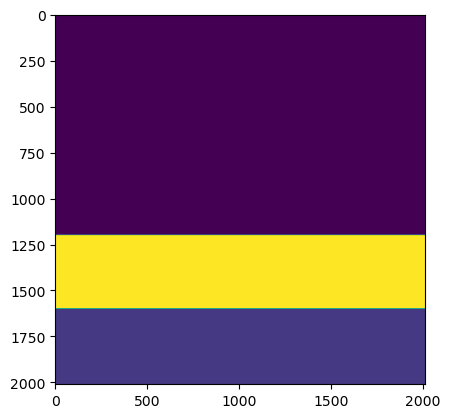

In [4]:
import numpy as np

with open("./wave_modelling_backend/test/a11.bin", "r") as f:
    a11 = np.fromfile(f, dtype=np.float32)
    a11 = a11.reshape(201, 201).T

import matplotlib.pyplot as plt
plt.imshow(np.sqrt(a11), extent=[0, 2010, 2010, 0])

To generate a finite difference gather, we need a parameter file. We have two in this notebook's backend. Each key corresponds to a different parameter for setting up the finite difference model

In [27]:
manFD.Grid_Info_Giorgos.info()

nxtot---------------total number of x grid points including nxabs-----------------------------------(integer)
nztot---------------total number of z grid points including nzabs-----------------------------------(integer)
nxabs---------------number of x  absorbing boundary points------------------------------------------(integer)
nzabs---------------number of z  absorbing boundary points------------------------------------------(integer)
dl------------------grid increment in meter---------------------------------------------------------(number)
nt------------------total number of time steps------------------------------------------------------(integer)
dt------------------time step increment in seconds--------------------------------------------------(number)
nsnap---------------number of snapshots for output--------------------------------------------------(integer)
fsnap---------------time step of first snapshot output----------------------------------------------(integer)
dsnap-------

We validate the parameter file and then run the finite difference simulation. We then visualize the results using the `matplotlib` library.

In [5]:
setup_parameters = manFD.JsonParameterFile(filename= "./wave_modelling_backend/small_model.json")
setup_parameters.validate_data()

JSON is valid


In [6]:
import mantis_wave_modelling.finite_difference.run_model as runFD

Finally, we run the simulation using the input parameter file for running and trace extraction:

In [7]:
import json
with open("./wave_modelling_backend/small_model_run.json", "r") as f:
    run_parameters = json.load(f)
print(run_parameters)

{'input_dir': './wave_modelling_backend/test', 'fpeak': 20, 'parmsfile': './wave_modelling_backend/small_model.json', 'wavetype': 0, 'wavetime': 0.09092, 'use_PML': 1, 'verbose': 1}


In [8]:
%%capture cap
runFD.main(infile = "./wave_modelling_backend/small_model_run.json")


In [44]:
with open("./wave_modelling_backend/output.txt", "w") as file:
    file.write(cap.stdout)

The snapshot and traces are saved in a subdir within the grids dir (no binaries are saved in github apart from images within the notebook)

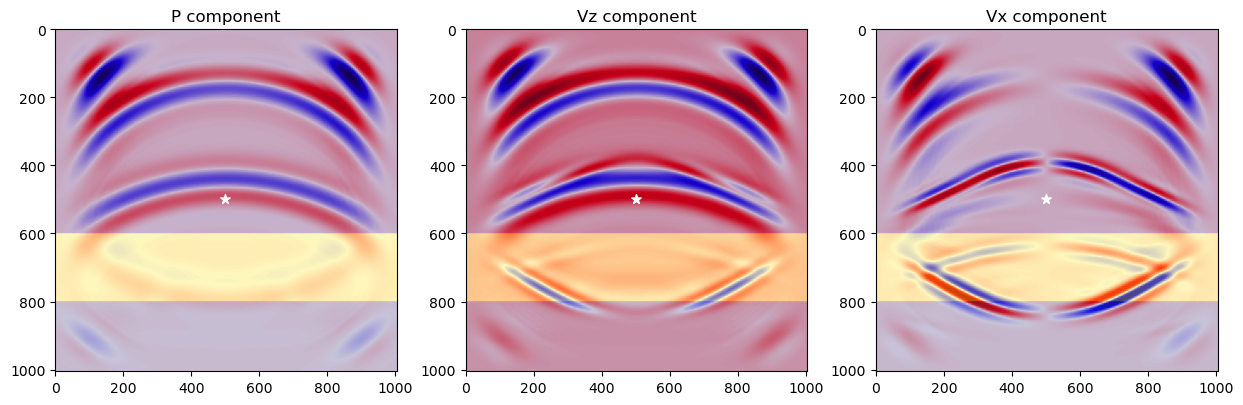

In [9]:
import numpy as np
import matplotlib.pyplot as plt
minx = 0
maxx = setup_parameters.data["nxtot"] * setup_parameters.data["dl"]
minz = 0
maxz = setup_parameters.data["nztot"] * setup_parameters.data["dl"]
sourcex = setup_parameters.data["x_source"]
sourcez = setup_parameters.data["z_source"]
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
components = ["P", "Vz", "Vx"]
for i, component in enumerate(components):
    image = np.fromfile(
        f"./wave_modelling_backend/test/snapshots/{component}-0005000.bin",
        dtype=np.dtype("float32"),
    ).reshape(201, 201)[::-1].T

    ax[i].imshow(image, extent=[minx, maxx, maxz, minz], label=component, cmap="seismic")
    ax[i].imshow(
        np.sqrt(a11), extent=[minx, maxx, maxz, minz], label=component, alpha=0.3
    )
    ax[i].scatter(sourcex, sourcez, c="w", s=50, marker="*", label="source")

    ax[i].set_title(f"{component} component")

This workflow is coupled to the rock physics model library. For instance, we can make the middle layer VTI model according to Hudson's model, and run the finite difference code on that grid.

In [10]:
import mantis_core.rock_physics.fluid as manFL
methane = manFL.Fluid.from_presets(name="Methane", pressure=10, temperature=40)
dic2 = dic.copy()
dic2[1] = {
    "model": "hudson",
    "parameters": {"crack_density": 0.1, "aspect_ratio": 0.01, "fluid": methane},
}

Now the model library is different

In [11]:
dic2

{0: {'model': 'generic', 'parameters': {}},
 1: {'model': 'hudson',
  'parameters': {'crack_density': 0.1,
   'aspect_ratio': 0.01,
   'fluid': Fluid(name='Methane', modulus=0.0146, viscosity=1.39e-05, density=0.07)}},
 2: {'model': 'generic', 'parameters': {}}}

We export this to a new laterally homogeneous model 

In [18]:
cij_grid2 = manFD.FiniteDifferenceGridFromRockPhysicsModels(
    well_input=input, mod_dictionary=dic2, label="hudson"
)
cij_grid2.save_modelling_grids(
    output_folder="wave_modelling_backend/hudson",
    n_x_grid_points=201,
    n_z_grid_points=201,
    dx=5.0,
    offset=500,
)

And we run the simulation again using a run parameter file that points to the new grid 

In [19]:
%%capture cap
runFD.main(infile = "./wave_modelling_backend/small_model_hudson_run.json")

And we show the same snapshots as before

ValueError: cannot reshape array of size 20301 into shape (201,201)

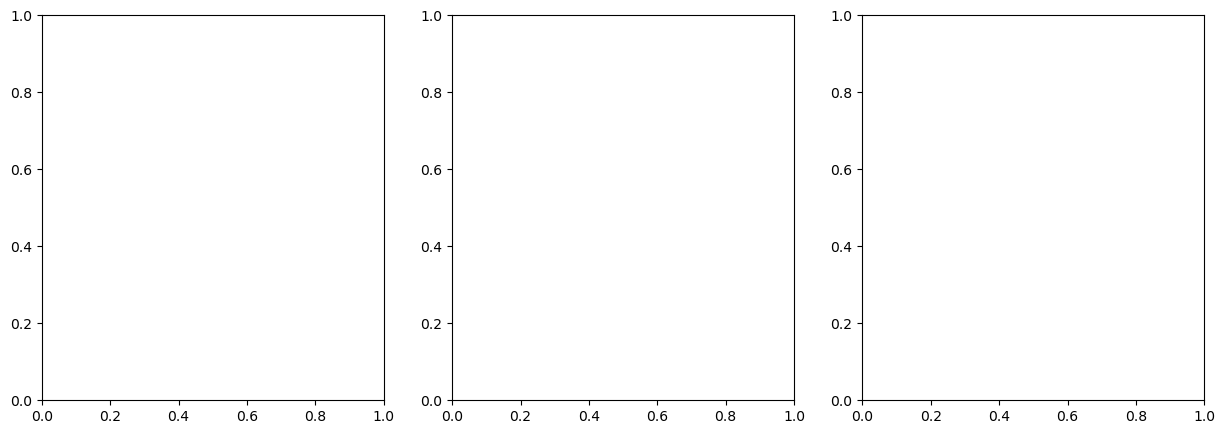

In [20]:
import numpy as np
import matplotlib.pyplot as plt
minx = 0
maxx = setup_parameters.data["nxtot"] * setup_parameters.data["dl"]
minz = 0
maxz = setup_parameters.data["nztot"] * setup_parameters.data["dl"]
sourcex = setup_parameters.data["x_source"]
sourcez = setup_parameters.data["z_source"]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
components = ["P", "Vz", "Vx"]
for i, component in enumerate(components):
    image = (
        np.fromfile(
            f"./wave_modelling_backend/temp/snapshots/{component}-0005000.bin",
            dtype=np.dtype("float32"),
        )
        .reshape(201, 201)[::-1]
        .T
    )

    ax[i].imshow(
        image, extent=[minx, maxx, maxz, minz], label=component, cmap="seismic"
    )
    ax[i].imshow(
        np.sqrt(a11), extent=[minx, maxx, maxz, minz], label=component, alpha=0.3
    )
    ax[i].scatter(sourcex, sourcez, c="w", s=50, marker="*", label="source")

    ax[i].set_title(f"{component} component")